In [1]:
# Gerekli kütüphaneleri yükleyin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Veri setlerini yükleyin
satis_verisi = pd.read_csv('satis_verisi_5000.csv')
musteri_verisi = pd.read_csv('musteri_verisi_5000_utf8.csv')



In [2]:
satis_verisi.isnull().sum()
musteri_verisi.isnull().sum()

musteri_id         0
isim               0
cinsiyet           0
yas                0
sehir              0
harcama_miktari    0
dtype: int64

In [2]:

# Görev 1: Veri Temizleme ve Manipülasyonu

# Sayısal sütunlarda eksik değerleri ortalama ile doldurma
satis_verisi = satis_verisi.apply(lambda x: x.fillna(x.mean()) if x.dtype in ['float64', 'int64'] else x)
musteri_verisi = musteri_verisi.apply(lambda x: x.fillna(x.mean()) if x.dtype in ['float64', 'int64'] else x)


# Aykırı değerleri tespit edin ve çıkarın
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

satis_verisi = remove_outliers(satis_verisi, 'fiyat')
musteri_verisi = remove_outliers(musteri_verisi, 'harcama_miktari')

# Veri setlerini musteri_id üzerinden birleştirin
veri = pd.merge(satis_verisi, musteri_verisi, on="musteri_id")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2232\3298155923.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aylik_satis = veri['toplam_satis'].resample('M').sum()


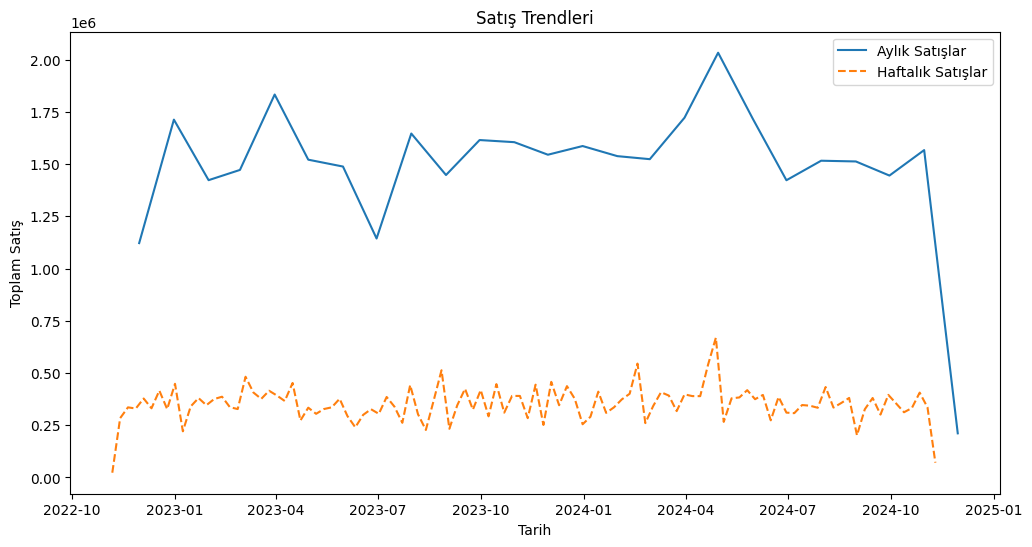

In [3]:
# Görev 2: Zaman Serisi Analizi

# Tarih sütununu datetime formatına çevirin
veri['tarih'] = pd.to_datetime(veri['tarih'])
veri['ay'] = veri['tarih'].dt.to_period('M')  # Aylık dönem olarak "ay" sütunu ekleniyor

# Haftalık ve aylık toplam satışların hesaplanması
veri.set_index('tarih', inplace=True)
haftalik_satis = veri['toplam_satis'].resample('W').sum()
aylik_satis = veri['toplam_satis'].resample('M').sum()

# Zaman serisi trendlerini görselleştirin
plt.figure(figsize=(12, 6))
plt.plot(aylik_satis, label='Aylık Satışlar')
plt.plot(haftalik_satis, label='Haftalık Satışlar', linestyle='--')
plt.title("Satış Trendleri")
plt.xlabel("Tarih")
plt.ylabel("Toplam Satış")
plt.legend()
plt.show()


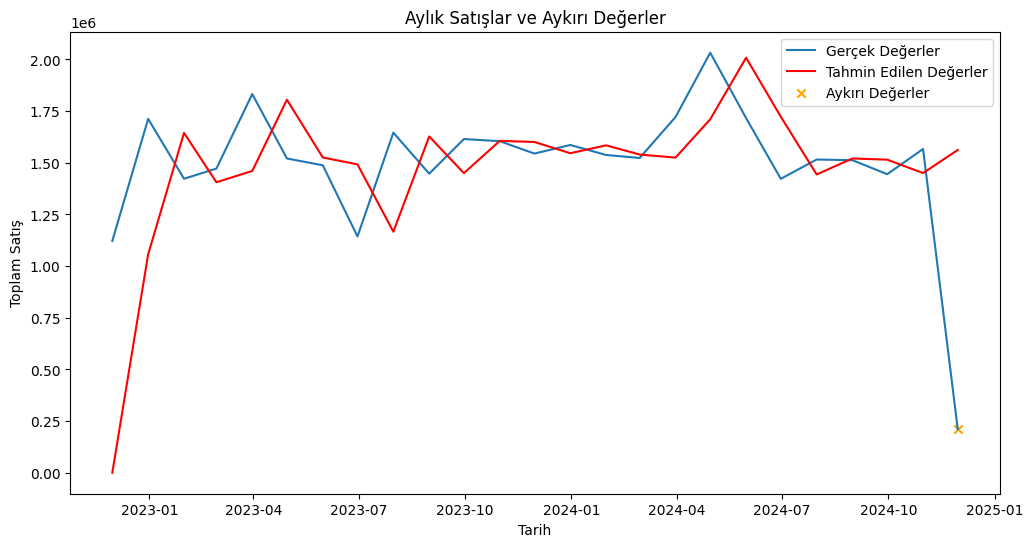

In [4]:

# ARIMA ile Zaman Serisi Aykırı Değer Analizi
model = ARIMA(aylik_satis, order=(1,1,1))
model_fit = model.fit()
aylik_satis = pd.DataFrame(aylik_satis)
aylik_satis['tahmin'] = model_fit.fittedvalues
aylik_satis['hata'] = aylik_satis['toplam_satis'] - aylik_satis['tahmin']
std_dev = aylik_satis['hata'].std()
aykiri_degerler = aylik_satis[np.abs(aylik_satis['hata']) > (3 * std_dev)]

plt.figure(figsize=(12, 6))
plt.plot(aylik_satis.index, aylik_satis['toplam_satis'], label='Gerçek Değerler')
plt.plot(aylik_satis.index, aylik_satis['tahmin'], color='red', label='Tahmin Edilen Değerler')
plt.scatter(aykiri_degerler.index, aykiri_degerler['toplam_satis'], color='orange', label='Aykırı Değerler', marker='x')
plt.title('Aylık Satışlar ve Aykırı Değerler')
plt.xlabel('Tarih')
plt.ylabel('Toplam Satış')
plt.legend()
plt.show()

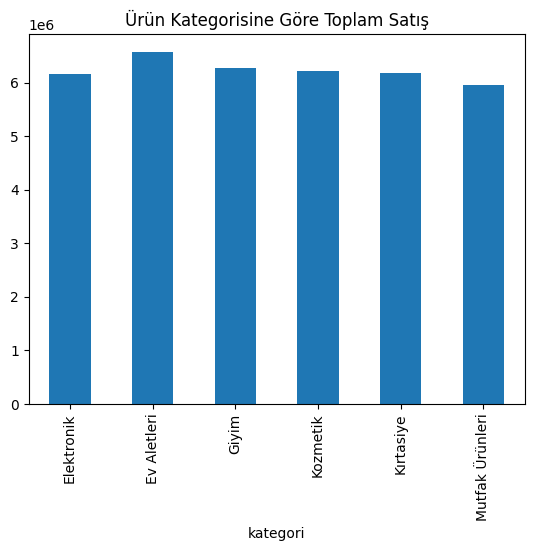

In [5]:
# Görev 3: Kategorisel ve Sayısal Analiz

# Ürün kategorilerine göre toplam satış
kategori_satis = veri.groupby('kategori')['toplam_satis'].sum()
kategori_satis.plot(kind='bar')
plt.title("Ürün Kategorisine Göre Toplam Satış")
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2232\1003807370.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yas_grubu_satis = veri.groupby('yas_grubu')['toplam_satis'].sum()


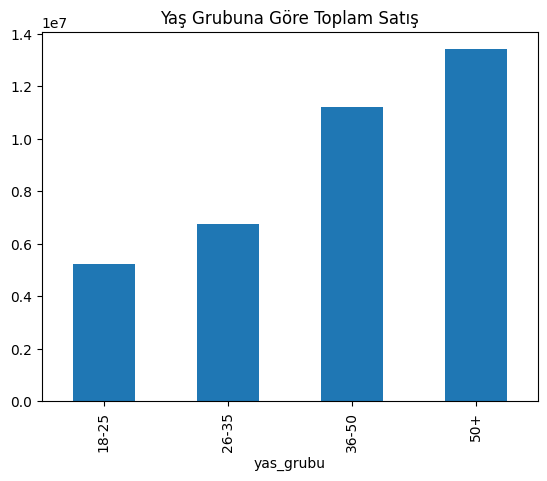

In [6]:

# Yaş gruplarına göre satış eğilimleri
veri['yas_grubu'] = pd.cut(veri['yas'], bins=[18, 25, 35, 50, 100], labels=['18-25', '26-35', '36-50', '50+'])
yas_grubu_satis = veri.groupby('yas_grubu')['toplam_satis'].sum()
yas_grubu_satis.plot(kind='bar')
plt.title("Yaş Grubuna Göre Toplam Satış")
plt.show()


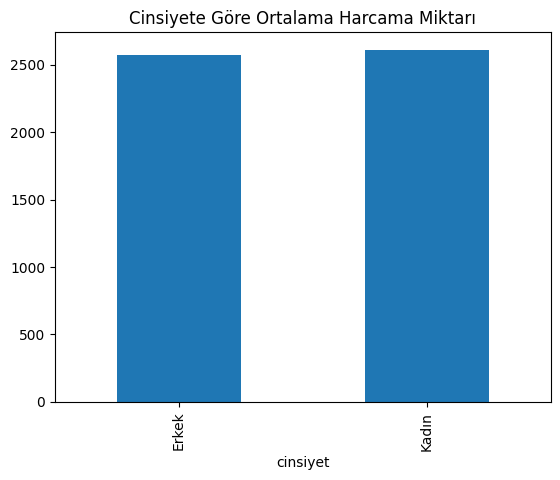

In [7]:

# Cinsiyete göre harcama miktarları
cinsiyet_harcama = veri.groupby('cinsiyet')['harcama_miktari'].mean()
cinsiyet_harcama.plot(kind='bar')
plt.title("Cinsiyete Göre Ortalama Harcama Miktarı")
plt.show()

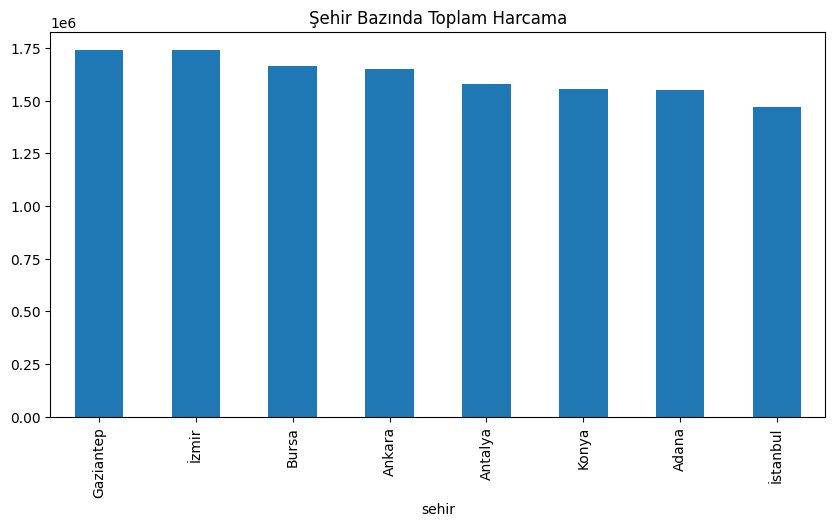

In [8]:
# Görev 4: İleri Düzey Veri Manipülasyonu

# Şehir bazında toplam harcama
sehir_harcama = veri.groupby('sehir')['harcama_miktari'].sum().sort_values(ascending=False)
sehir_harcama.plot(kind='bar', figsize=(10, 5))
plt.title("Şehir Bazında Toplam Harcama")
plt.show()


In [9]:

# Her ürün için ortalama satış artış oranı
veri['ay'] = veri.index.month
urun_aylik_satis = veri.groupby(['ürün_kodu', 'ay'])['toplam_satis'].sum().unstack()
urun_aylik_degisiklik = urun_aylik_satis.pct_change(axis=1) * 100
urun_ortalama_artis = urun_aylik_degisiklik.mean(axis=1)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2232\393420305.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  urun_aylik_degisiklik = urun_aylik_satis.pct_change(axis=1) * 100


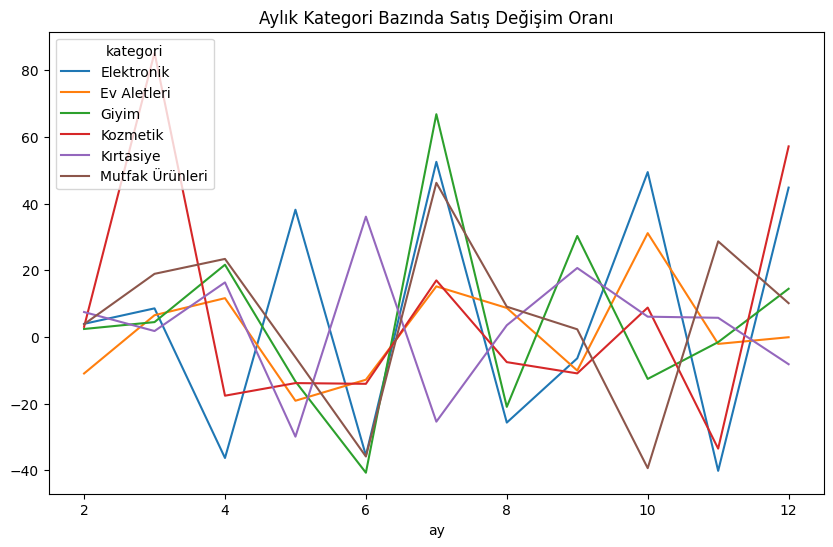

In [10]:

# Aylık toplam satış değişim oranı
kategori_aylik_satis = veri.groupby(['kategori', 'ay'])['toplam_satis'].sum().unstack()
kategori_aylik_degisiklik = kategori_aylik_satis.pct_change(axis=1) * 100
kategori_aylik_degisiklik.T.plot(figsize=(10, 6))
plt.title("Aylık Kategori Bazında Satış Değişim Oranı")
plt.show()

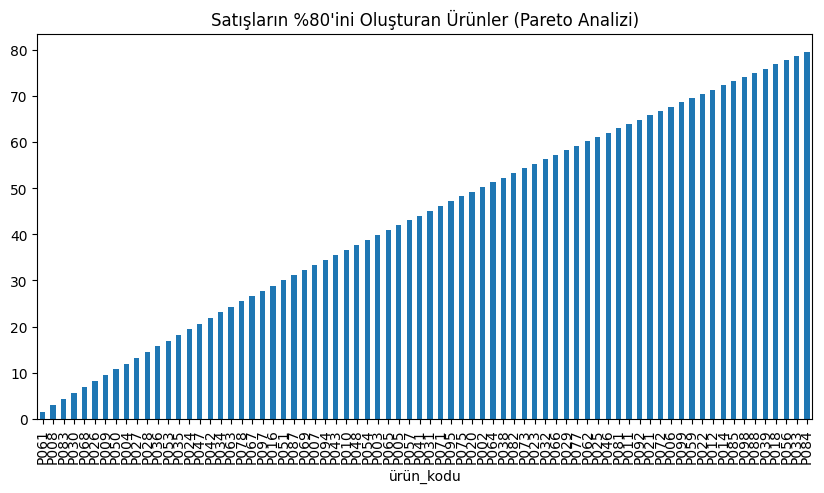

In [11]:
# Görev 5: Ekstra (BONUS)

# Pareto Analizi (80/20 kuralı)
urun_satis = veri.groupby('ürün_kodu')['toplam_satis'].sum().sort_values(ascending=False)
toplam_satis = urun_satis.sum()
urun_satis_yuzde = (urun_satis.cumsum() / toplam_satis) * 100
pareto_urunler = urun_satis_yuzde[urun_satis_yuzde <= 80]

plt.figure(figsize=(10, 5))
pareto_urunler.plot(kind='bar')
plt.title("Satışların %80'ini Oluşturan Ürünler (Pareto Analizi)")
plt.show()

In [12]:
# Basit Lineer Regresyon ile Tahmin Modeli
aylik_satis.reset_index(inplace=True)
X = aylik_satis.index.values.reshape(-1, 1)
y = aylik_satis['toplam_satis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Mean Squared Error: 90619833698.91592


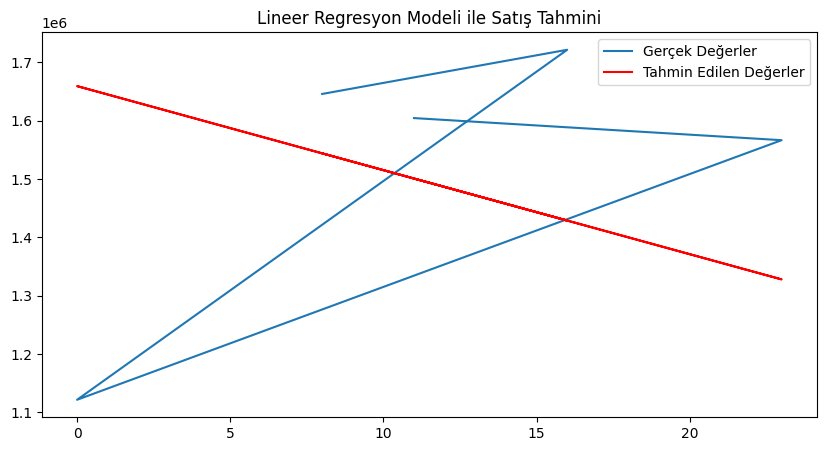

In [13]:

# Model performansını değerlendirme
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Gerçek Değerler")
plt.plot(y_test.index, y_pred, color='red', label="Tahmin Edilen Değerler")
plt.title("Lineer Regresyon Modeli ile Satış Tahmini")
plt.legend()
plt.show()